# **SPAM DETECTION**

### In this notebook I explore methods of spam detection:


|      model     | accuracy | f1-score | precision | recall |
|----------------|----------|----------|-----------|--------|
| Naive Bayes    | accuracy | f1-score | precision | recall |
| LLM classifier | accuracy | f1-score | precision | recall |
| SVM            | accuracy | f1-score | precision | recall |
| CatBoost       | accuracy | f1-score | precision | recall |
| LinearClassifer| accuracy | f1-score | precision | recall |

## imports & hyperparameters

In [9]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from string import punctuation

import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import shutil
import os

In [26]:
DATASET_NAME = "naserabdullahalam/phishing-email-dataset"
DATA_PATH = Path("../../data") 
TRAIN_DATA_PATH = Path("../../data") / "train"
TRAIN_FILE_NAME = TRAIN_DATA_PATH / "train.csv"

STOPWORDS = set(stopwords.words("english"))

## combine data

download data

In [7]:
temp_path = kagglehub.dataset_download(DATASET_NAME)

shutil.move(Path(temp_path), DATA_PATH) 

(DATA_PATH / "1").rename(TRAIN_DATA_PATH)

print(f'Files has been downloaded in {DATA_PATH}/train')

100%|██████████| 77.1M/77.1M [00:17<00:00, 4.57MB/s]

Extracting files...


Files has been downloaded in ../../data/train


check class balance

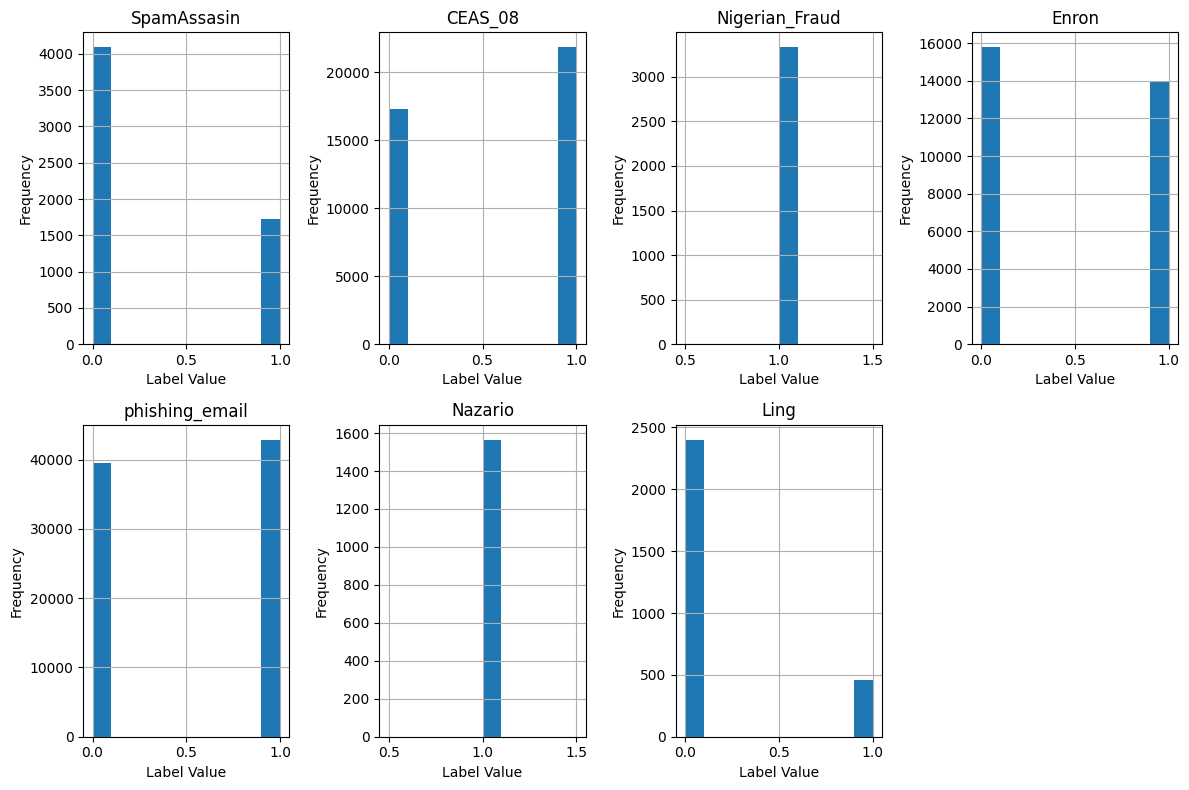

IN TOTAL:
 * spam - 85782
 * not spam - 79190


In [8]:
plt.figure(figsize=(12, 8))
zeros, ones = 0, 0
for ind, df_name in enumerate(os.listdir(TRAIN_DATA_PATH), start=1):
    df = pd.read_csv(TRAIN_DATA_PATH / df_name)
    plt.subplot(2, 4, ind)
    counted_val = df["label"].value_counts()

    if (len(counted_val) == 2):
        zeros += counted_val[0]
    ones += counted_val[1]

    df["label"].hist()
    plt.title(Path(df_name).stem)    
    plt.xlabel("Label Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

print(f"IN TOTAL:\n * spam - {ones}\n * not spam - {zeros}")

take a look at all datasets

In [9]:
spam_assasin_df = pd.read_csv(TRAIN_DATA_PATH / "SpamAssasin.csv")
spam_assasin_df.head()

,sender,receiver,date,subject,body,label,urls
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,"Thu, 22 Aug 2002 18:26:25 +0700",Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...","Thu, 22 Aug 2002 12:46:18 +0100",[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1
2,"""Tim Chapman"" <timc@2ubh.com>",zzzzteana <zzzzteana@yahoogroups.com>,"Thu, 22 Aug 2002 13:52:38 +0100",[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient: ;,"Thu, 22 Aug 2002 09:15:25 -0400",[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,"Thu, 22 Aug 2002 14:38:22 +0100",Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1


In [10]:
ceas_df = pd.read_csv(TRAIN_DATA_PATH / "CEAS_08.csv")
ceas_df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [11]:
nig_fraud_df = pd.read_csv(TRAIN_DATA_PATH / "Nigerian_Fraud.csv")
nig_fraud_df.head()

,sender,receiver,date,subject,body,urls,label
0,MR. JAMES NGOLA. <james_ngola2002@maktoob.com>,webmaster@aclweb.org,"Thu, 31 Oct 2002 02:38:20 +0000",URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...,0,1
1,Mr. Ben Suleman <bensul2004nng@spinfinder.com>,R@M,"Thu, 31 Oct 2002 05:10:00 -0000",URGENT ASSISTANCE /RELATIONSHIP (P),"Dear Friend,\n\nI am Mr. Ben Suleman a custom ...",0,1
2,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,"Thu, 31 Oct 2002 22:17:55 +0100",GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1
3,PRINCE OBONG ELEME <obong_715@epatra.com>,webmaster@aclweb.org,"Thu, 31 Oct 2002 22:44:20 -0000",GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,0,1
4,Maryam Abacha <m_abacha03@www.com>,R@M,"Fri, 01 Nov 2002 01:45:04 +0100",I Need Your Assistance.,"Dear sir, \n \nIt is with a heart full of hope...",0,1


In [12]:
enron_df = pd.read_csv(TRAIN_DATA_PATH / "Enron.csv")
enron_df.head()

,subject,body,label
0,"hpl nom for may 25 , 2001",( see attached file : hplno 525 . xls )\r\n- h...,0
1,re : nom / actual vols for 24 th,- - - - - - - - - - - - - - - - - - - - - - fo...,0
2,"enron actuals for march 30 - april 1 , 201","estimated actuals\r\nmarch 30 , 2001\r\nno flo...",0
3,"hpl nom for may 30 , 2001",( see attached file : hplno 530 . xls )\r\n- h...,0
4,"hpl nom for june 1 , 2001",( see attached file : hplno 601 . xls )\r\n- h...,0


In [13]:
phishing_df = pd.read_csv(TRAIN_DATA_PATH / "phishing_email.csv")
phishing_df.head()

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


In [14]:
nazario_df = pd.read_csv(TRAIN_DATA_PATH / "Nazario.csv")
nazario_df.head()

,sender,receiver,date,subject,body,urls,label
0,Mail System Internal Data <MAILER-DAEMON@monke...,NaN,28 Sep 2017 09:57:25 -0400,DON'T DELETE THIS MESSAGE -- FOLDER INTERNAL DATA,This text is part of the internal format of yo...,1,1
1,cPanel <service@cpanel.com>,jose@monkey.org,"Fri, 30 Oct 2015 00:00:48 -0500",Verify Your Account,Business with \t\t\t\t\t\t\t\tcPanel & WHM \t...,1,1
2,Microsoft Outlook <recepcao@unimedceara.com.br>,NaN,"Fri, 30 Oct 2015 06:21:59 -0300 (BRT)",Helpdesk Mailbox Alert!!!,Your two incoming mails were placed on pending...,1,1
3,Ann Garcia <AnGarcia@mcoe.org>,"""info@maaaaa.org"" <info@maaaaa.org>","Fri, 30 Oct 2015 14:54:33 +0000",IT-Service Help Desk,Password will expire in 3 days. Click Here To ...,0,1
4,"""USAA"" <usaaacctupdate@sccu4u.com>",Recipients <usaaacctupdate@sccu4u.com>,"Fri, 30 Oct 2015 14:02:33 -0500",Final USAA Reminder - Update Your Account Now,"To ensure delivery to your inbox, please add U...",1,1


In [15]:
ling_df = pd.read_csv(TRAIN_DATA_PATH / "Ling.csv")
ling_df.head()

,subject,body,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


leave only mail and label and combine all datasets in one csv file

In [16]:
spam_assasin_df["mail"] = spam_assasin_df["subject"] + spam_assasin_df["body"]
spam_assasin_df = spam_assasin_df[["mail", "label"]]

ceas_df["mail"] = ceas_df["subject"] + ceas_df["body"]
ceas_df = ceas_df[["mail", "label"]]

nig_fraud_df["mail"] = nig_fraud_df["subject"] + nig_fraud_df["body"]
nig_fraud_df = nig_fraud_df[["mail", "label"]]

enron_df["mail"] = enron_df["subject"] + enron_df["body"]
enron_df = enron_df[["mail", "label"]]

phishing_df["mail"] = phishing_df["text_combined"]
phishing_df = phishing_df[["mail", "label"]]

nazario_df["mail"] = nazario_df["subject"] + nazario_df["body"]
nazario_df = nazario_df[["mail", "label"]]

ling_df["mail"] = ling_df["subject"] + ling_df["body"]
ling_df = ling_df[["mail", "label"]]


train_df = pd.concat([spam_assasin_df, ceas_df, nig_fraud_df, enron_df, phishing_df, nazario_df, ling_df], axis=0)
train_df = train_df.dropna()
train_df.to_csv(TRAIN_FILE_NAME, index=False)

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 164624 entries, 0 to 2858
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   mail    164624 non-null  object
 1   label   164624 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ MB


## SVM

In [4]:
train_df = pd.read_csv(TRAIN_FILE_NAME)
train_df.head()

,mail,label
0,"Re: New Sequences WindowDate: Wed, 21 A...",0
1,[zzzzteana] RE: AlexanderMartin A posted:\nTas...,0
2,[zzzzteana] Moscow bomberMan Threatens Explosi...,0
3,[IRR] Klez: The Virus That Won't DieKlez: The...,0
4,Re: [zzzzteana] Nothing like mama used to make...,0


In [33]:
def preprocess_text(text: str) -> str:
    stemmer = SnowballStemmer("english")
    clean_text = re.sub(r'[^\w\s]', '', text)
    clean_text = ' '.join([stemmer.stem(x) for x in clean_text.lower().split() if x not in STOPWORDS]) 
    return clean_text
preprocess_text(train_df.values[0, 0])

'new sequenc windowd wed 21 aug 2002 105446 0500 chris garrigu messageid 10299452874797tmdadeepeddyvirciocom cant reproduc error repeat like everi time without fail debug log pick happen 181903 pick_it exec pick inbox list lbrace lbrace subject ftp rbrace rbrace 48524852 sequenc mercuri 181903 exec pick inbox list lbrace lbrace subject ftp rbrace rbrace 48524852 sequenc mercuri 181904 ftoc_pickmsg 1 hit 181904 mark 1 hit 181904 tkerror syntax error express int note run pick command hand delta pick inbox list lbrace lbrace subject ftp rbrace rbrace 48524852 sequenc mercuri 1 hit that 1 hit come obvious version nmh im use delta pick version pick nmh104 compil fuchsiacsmuozau sun mar 17 145556 ict 2002 relev part mh_profil delta mhparam pick seq sel list sinc pick command work sequenc actual one that explicit command line search popup one come mh_profil get creat kre ps still use version code form day ago havent abl reach cvs repositori today local rout issu think ________________________